# Detecting Cancer in Gigapixel Pathology Images - Part 1

## COMS W4995 Applied Deep Learning

Pranav Alva pa2541

Megala Kannan msk2245

Link to YouTube video: https://youtu.be/U3qlaW_XpUQ

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


Extracting and storing data

In [0]:
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [0]:
colab_root = "/content/" 
SLIDES_URL = "https://storage.googleapis.com/dsi_originals/slide_small.zip"

In [0]:
slides_file = os.path.join(colab_root, "slides.zip")
images_folder = os.path.join(colab_root, 'slides/')
download_if_missing(SLIDES_URL,
                    slides_file,
                    extract=False)

10554318848/10554312884 [==============================] - 233s 0us/step


'/content/slides.zip'

In [0]:
!7z x slides.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 10554312884 bytes (10066 MiB)

Extracting archive: slides.zip
--
Path = slides.zip
Type = zip
Physical Size = 10554312884
64-bit = +

  0%      0% 1 - slide_small/tumor_075.tif                                    1% 1 - slide_small/tumor_075.tif                                    2% 1 - slide_small/tumor_075.tif                                    3% 1 - slide_small/tumor_075.tif                                    4% 1 - slide_small/tumor_075.

In [0]:
slide_paths = []
mask_paths = []

for file in os.listdir("/content/slide_small"):
  if file.endswith("mask.tif"):
    mask_paths.append(os.path.join("/content/slide_small", file))
  elif file.endswith(".tif"):
    slide_paths.append(os.path.join("/content/slide_small", file))

slide_paths.sort()
mask_paths.sort()

In [0]:
train_img = slide_paths[0:3]
test_img = slide_paths[3:8]
train_mask = mask_paths[0:3]
test_mask = mask_paths[3:8]

Starter functions

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where((im_gray <= intensity) &(im_gray !=0))
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked


Patch Extraction

In [0]:
def patch_extraction(train_img, train_mask, zoom_level, ds_factor, stride_size, patch_size, offset):
  image_patches = []
  image_masks = []

  for k in range(0, len(train_img)):
    img = train_img[k]
    img_mask = train_mask[k]
    slide = open_slide(img)
    tumor_mask = open_slide(img_mask)
    for j in range(0,slide.level_dimensions[zoom_level][1],stride_size):
      for i in range(0,slide.level_dimensions[zoom_level][0], stride_size):
        patch = read_slide(slide,(i*ds_factor)-(offset*ds_factor),(j*ds_factor)-(offset*ds_factor),level = zoom_level, width = patch_size,height = patch_size) 
        mask_patch = read_slide(tumor_mask,(i*ds_factor)-(offset*ds_factor),(j*ds_factor)-(offset*ds_factor),level = zoom_level, width = patch_size,height = patch_size)
        mask_patch = mask_patch[:,:,0]
        tissue_pixels = find_tissue_pixels(patch)
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
        if percent_tissue > 20:
          image_patches.append(patch)
          image_masks.append(mask_patch)
  return image_patches, image_masks

Assigning patch labels

In [0]:
def assign_labels(image_masks):
  image_labels = []
  for mask in image_masks:
    if np.count_nonzero(mask[20:60,20:60]) > 0:
      image_labels.append(1)
    else :
      image_labels.append(0)
  image_labels = np.array(image_labels)
  return image_labels

Handling class imbalance: Upsampling minority class

In [0]:
def class_balanced(image_patches, image_labels):
  class0 = np.where(image_labels==0)[0]
  class1= np.where(image_labels==1)[0]
  class1_upsampled = np.random.choice(class1, size = len(class0), replace= True)
  assert(len(class1_upsampled)==len(class0))
  
  image_patches_0 = list(image_patches[class0])
  image_patches_1= list(image_patches[class1_upsampled])
  for array in image_patches_1:
    image_patches_0.append(array)
  image_patches = np.array(image_patches_0)

  image_labels_0 = list(image_labels[class0])
  image_labels_1= list(image_labels[class1_upsampled])
  for array in image_labels_1:
    image_labels_0.append(array)
  image_labels = np.array(image_labels_0)
  return image_patches, image_labels

Predict Function

In [0]:
def predict_test_image(img, img_mask, model):
  slide = open_slide(img)
  tumor_mask = open_slide(img_mask)
  predictions = []
  pred_mask = np.full((slide.level_dimensions[zoom_level][1], slide.level_dimensions[zoom_level][0]), 0.0)

  for j in range(0,slide.level_dimensions[zoom_level][1],stride_size):
    for i in range(0,slide.level_dimensions[zoom_level][0], stride_size):
      patch = read_slide(slide,
                         (i*ds_factor)-(stride_size*ds_factor),
                         (j*ds_factor)-(stride_size*ds_factor),
                         level = zoom_level,
                         width = patch_size,
                         height = patch_size) 
      tissue_pixels = find_tissue_pixels(patch)
      tissue_pixels = list(tissue_pixels)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[0]) * 100
      #patch = apply_mask(patch, tissue_pixels, (255,0,0))
      patch = patch /255.0
      #print(percent_tissue)
      prediction = model.predict(patch.reshape((1, patch_size, patch_size, -1)))[0,0]
      #print(prediction)
      if percent_tissue > 20:
        if (i+stride_size) > slide.level_dimensions[zoom_level][0] and (j+stride_size) > slide.level_dimensions[zoom_level][1]:
            i_offset = slide.level_dimensions[zoom_level][0] - i
            j_offset = slide.level_dimensions[zoom_level][1] - j
            pred_mask[j:j+j_offset,i:i+i_offset] = np.full((j_offset, i_offset), prediction)
          
        elif (i+stride_size) > slide.level_dimensions[zoom_level][0]:
          i_offset = slide.level_dimensions[zoom_level][0] - i
          pred_mask[j:j+stride_size,i:i+i_offset] = np.full((stride_size, i_offset), prediction)
          
        elif (j+stride_size) > slide.level_dimensions[zoom_level][1]:
          j_offset = slide.level_dimensions[zoom_level][1] - j
          pred_mask[j:j+j_offset,i:i+stride_size] = np.full((j_offset, stride_size), prediction)
          
        else:
          pred_mask[j:j+stride_size,i:i+stride_size] = np.full((stride_size, stride_size), prediction)
      else:
        if (i+stride_size) > slide.level_dimensions[zoom_level][0] and (j+stride_size) > slide.level_dimensions[zoom_level][1]:
          i_offset = slide.level_dimensions[zoom_level][0] - i
          j_offset = slide.level_dimensions[zoom_level][1] - j
          pred_mask[j:j+j_offset,i:i+i_offset] = np.full((j_offset, i_offset), 0.0)
          
        elif (i+stride_size) > slide.level_dimensions[zoom_level][0]:
          i_offset = slide.level_dimensions[zoom_level][0] - i
          pred_mask[j:j+stride_size,i:i+i_offset] = np.full((stride_size, i_offset), 0.0)
          
        elif (j+stride_size) > slide.level_dimensions[zoom_level][1]:
          j_offset = slide.level_dimensions[zoom_level][1] - j
          pred_mask[j:j+j_offset,i:i+stride_size] = np.full((j_offset, stride_size), 0.0)
          
        else:
          pred_mask[j:j+stride_size,i:i+stride_size] = np.full((stride_size, stride_size), 0.0)
  return pred_mask

Evaluation metrics

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score

def eval_metrics(y_true, y_pred):
  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  iou_score = np.sum(intersection) / np.sum(union)

  CM = confusion_matrix(y_true, y_pred)
  TN = CM[0][0]
  FN = CM[1][0]
  TP = CM[1][1]
  FP = CM[0][1]
  
  sens = TP / (TP + FN)
  spec = TN / (TN + FP)
  return iou_score, sens, spec

Extracting patches at zoom level 4 

In [0]:
zoom_level = 4
ds_factor = 16
stride_size = 40
patch_size = 80
offset = 20

image_patches, image_masks = patch_extraction(train_img, train_mask, zoom_level, ds_factor, 
                                              stride_size, patch_size, offset)

In [0]:
assert len(image_patches) == len(image_masks)

In [0]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers

base = InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(80, 80, 3))
model = Sequential()
model.add(base)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
base.trainable = False

In [0]:
image_patches = np.array(image_patches)
image_masks = np.array(image_masks) 

In [0]:
image_patches.shape

(17617, 80, 80, 3)

In [0]:
image_masks.shape

(17617, 80, 80)

Displaying patch and corresponding mask

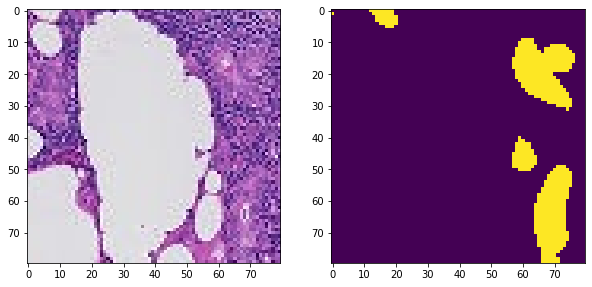

In [0]:
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(image_patches[170]) 
plt.subplot(1,2,2)
plt.imshow(image_masks[170])

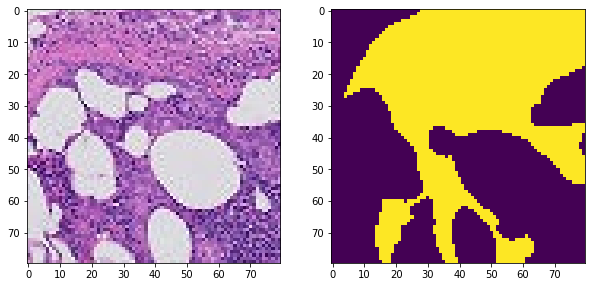

In [0]:
plt.figure(figsize= (10,5))
plt.subplot(1, 2, 1)
plt.imshow(image_patches[100]) 
plt.subplot(1,2,2)
plt.imshow(image_masks[100])

In [0]:
image_labels = assign_labels(image_masks)

In [0]:
image_patches_bal, image_labels_bal = class_balanced(image_patches, image_labels)

In [0]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(image_patches_bal, image_labels_bal, 
                                                    test_size=0.3,stratify = image_labels_bal)


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( rescale= 1./255)
val_datagen = ImageDataGenerator( rescale= 1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=True)

Baseline Inception V3 model

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
#sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=1e-4)
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(train_generator,
                              steps_per_epoch = len(X_train) //32,
                              epochs = 10,
                              validation_data = val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 618 steps, validate for 266 steps
Epoch 1/10
618/618 [==============================] - 23s 38ms/step - loss: 0.6314 - accuracy: 0.6462 - val_loss: 1.3087 - val_accuracy: 0.4914
Epoch 2/10
618/618 [==============================] - 19s 31ms/step - loss: 0.5782 - accuracy: 0.6997 - val_loss: 1.3075 - val_accuracy: 0.4846
Epoch 3/10
618/618 [==============================] - 19s 31ms/step - loss: 0.5666 - accuracy: 0.7111 - val_loss: 1.2956 - val_accuracy: 0.4862
Epoch 4/10
618/618 [==============================] - 20s 32ms/step - loss: 0.5559 - accuracy: 0.7178 - val_loss: 1.2419 - val_accuracy: 0.4903
Epoch 5/10
618/618 [==============================] - 20s 32ms/step - loss: 0.5499 - accuracy: 0.7247 - val_loss: 1.3737 - val_accuracy: 0.4883
Epoch 6/10
618/618 [==============================] - 20s 32ms/step - loss: 0.5467 - accuracy: 0.7261 - val_loss: 1.3292 - val_accuracy: 0.4934
Epoch 7/10
618/618 [======================

In [0]:
history = model.fit(train_generator,
                              steps_per_epoch = len(X_train) //32,
                              epochs = 10,
                              validation_data = val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 618 steps, validate for 266 steps
Epoch 1/10
618/618 [==============================] - 21s 33ms/step - loss: 0.7753 - accuracy: 0.4938 - val_loss: 0.7639 - val_accuracy: 0.5300
Epoch 2/10
618/618 [==============================] - 19s 31ms/step - loss: 0.7300 - accuracy: 0.5101 - val_loss: 0.7429 - val_accuracy: 0.5243
Epoch 3/10
618/618 [==============================] - 19s 31ms/step - loss: 0.7157 - accuracy: 0.5208 - val_loss: 0.7377 - val_accuracy: 0.5184
Epoch 4/10
618/618 [==============================] - 19s 31ms/step - loss: 0.7058 - accuracy: 0.5335 - val_loss: 0.7379 - val_accuracy: 0.5119
Epoch 5/10
618/618 [==============================] - 19s 31ms/step - loss: 0.6998 - accuracy: 0.5471 - val_loss: 0.7394 - val_accuracy: 0.5066
Epoch 6/10
618/618 [==============================] - 19s 31ms/step - loss: 0.6912 - accuracy: 0.5515 - val_loss: 0.7413 - val_accuracy: 0.5031
Epoch 7/10
618/618 [======================

In [0]:
from tensorflow import saved_model

saved_model.save(model, "/content")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/assets


Predicting on test slides

In [0]:
img = test_img[0]
img_mask = test_mask[0]
slide = open_slide(img)
tumor_mask = open_slide(img_mask)

In [0]:
pred_mask = predict_test_image(img, img_mask, model)

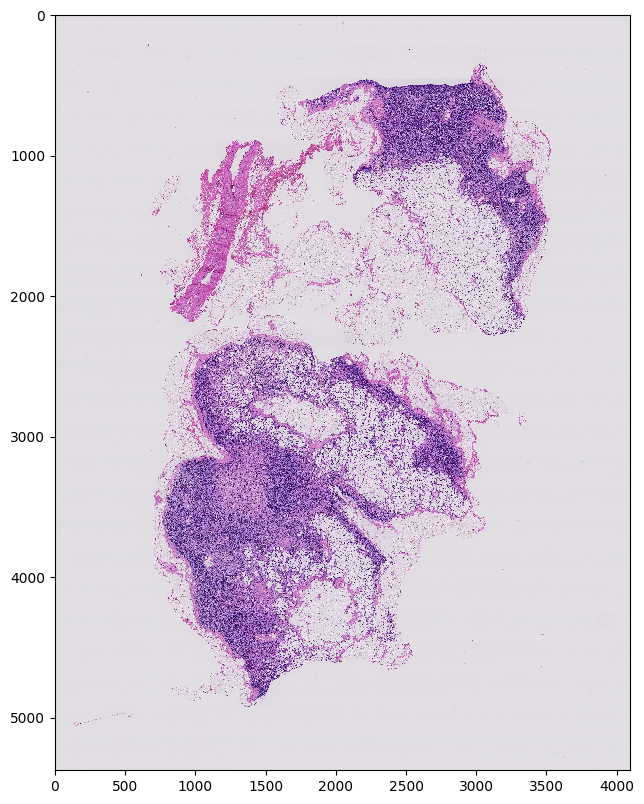

In [0]:
slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

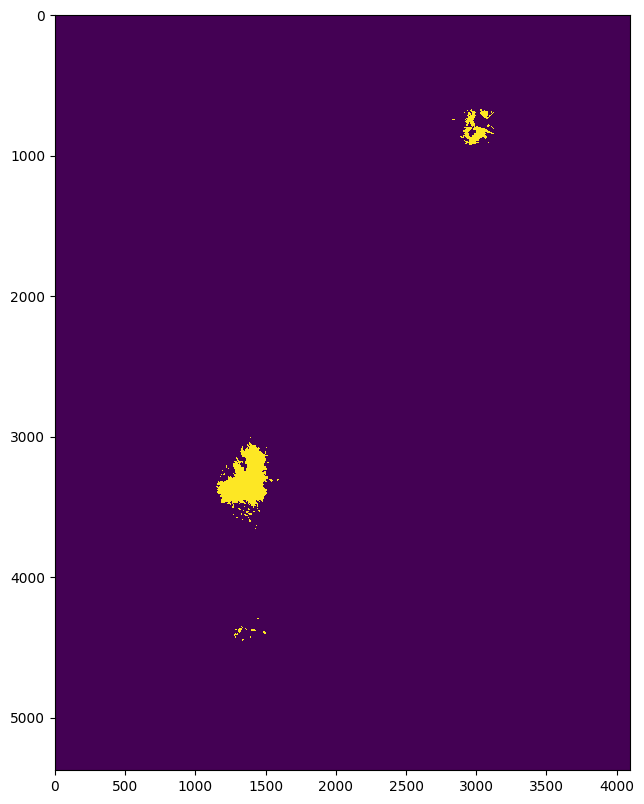

In [0]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

In [0]:
pred_mask.shape

(5376, 4096)

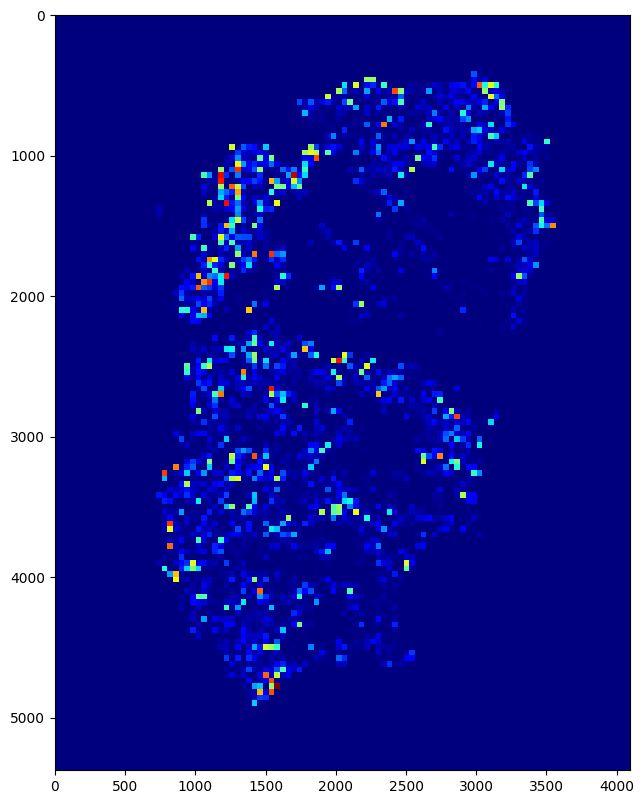

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask, cmap = 'jet')
plt.savefig('base_pred1')

Evaluate on test slides

In [0]:
y_true = mask_image.flatten()
y_pred = pred_mask.flatten()

In [0]:
rec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  rec_list.append(recall_score(y_true,new_pred))

In [0]:
print(np.linspace(0.1,0.5,8))

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5       ]


In [0]:
rec_list

[0.30577755512590704,
 0.185889959531283,
 0.1331553857835041,
 0.10855322379904973,
 0.06384977260807966,
 0.04996360163753493,
 0.04866421923555611,
 0.04465648556198289]

In [0]:
prec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  prec_list.append(precision_score(y_true,new_pred))

In [0]:
prec_list

[0.033675862068965515,
 0.031051255230125523,
 0.030376785714285714,
 0.030845195729537367,
 0.023173295454545453,
 0.02292744252873563,
 0.02836222627737226,
 0.0330150462962963]

In [0]:
#using probability threshold 0.2
y_pred_new = np.where(y_pred > 0.2, 1, 0)

In [0]:
iou, sens, spec = eval_metrics(y_true, y_pred_new)

In [0]:
print(iou)

0.028875382069066036


In [0]:
print(spec)

0.9732419686645691


In [0]:
print(classification_report(y_true, y_pred_new, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.99      0.97      0.98  21892343
     class 1       0.03      0.16      0.06    127753

    accuracy                           0.97  22020096
   macro avg       0.51      0.57      0.52  22020096
weighted avg       0.99      0.97      0.98  22020096



Define Custom CNN model

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
input_img = Input(shape=(80,80,3))

x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_custom = Model(inputs=input_img, outputs=predictions)
model_custom.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d_382 (Conv2D)          (None, 78, 78, 16)        448       
_________________________________________________________________
conv2d_383 (Conv2D)          (None, 76, 76, 16)        2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_384 (Conv2D)          (None, 36, 36, 32)        4640      
_________________________________________________________________
conv2d_385 (Conv2D)          (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 32)        0   

In [0]:
#sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=1e-4)
model_custom.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history_custom = model_custom.fit_generator(train_generator,
                              steps_per_epoch = len(X_train) //32,
                              epochs = 10,
                              validation_data = val_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 618 steps, validate for 266 steps
Epoch 1/10
618/618 [==============================] - 7s 11ms/step - loss: 0.3694 - accuracy: 0.8335 - val_loss: 0.2955 - val_accuracy: 0.8677
Epoch 2/10
618/618 [==============================] - 6s 10ms/step - loss: 0.2411 - accuracy: 0.8991 - val_loss: 0.1953 - val_accuracy: 0.9130
Epoch 3/10
618/618 [==============================] - 6s 9ms/step - loss: 0.1916 - accuracy: 0.9199 - val_loss: 0.1551 - val_accuracy: 0.9353
Epoch 4/10
618/618 [==============================] - 6s 10ms/step - loss: 0.1470 - accuracy: 0.9422 - val_loss: 0.1357 - val_accuracy: 0.9503
Epoch 5/10
618/618 [==============================] - 6s 10ms/step - loss: 0.1187 - accuracy: 0.9538 - val_loss: 0.0982 - val_accuracy: 0.9646
Epoch 6/10
618/618 [==============================] - 6s 10ms/step - loss: 0.1023 - accuracy: 0.9622 - val_loss: 0.0892 - val_accuracy: 0.9671
Epoch 7/10
618/618 [=============================

Data Augmentation

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator=validation_datagen.flow(X_val, y_val, batch_size=32)

In [0]:
for data_batch, labels_batch in train_generator:
    for x in data_batch:
      x = tf.image.random_hue(x, 0.04)
      x = tf.image.random_saturation(x, 0.0, 0.25)
      x = tf.image.random_brightness(x, 0.284)
      x = tf.image.random_contrast(x, 0.0, 0.75)
    break

In [0]:
history_augment = model_custom.fit_generator(train_generator,
                              steps_per_epoch = len(X_train) //32,
                              epochs = 10,
                              validation_data = validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 618 steps, validate for 266 steps
Epoch 1/10
618/618 [==============================] - 31s 50ms/step - loss: 0.2495 - accuracy: 0.9013 - val_loss: 0.9939 - val_accuracy: 0.5387
Epoch 2/10
618/618 [==============================] - 31s 50ms/step - loss: 0.1640 - accuracy: 0.9365 - val_loss: 0.6997 - val_accuracy: 0.5950
Epoch 3/10
618/618 [==============================] - 30s 49ms/step - loss: 0.1443 - accuracy: 0.9466 - val_loss: 0.8621 - val_accuracy: 0.5594
Epoch 4/10
618/618 [==============================] - 31s 49ms/step - loss: 0.1463 - accuracy: 0.9467 - val_loss: 0.7536 - val_accuracy: 0.5890
Epoch 5/10
618/618 [==============================] - 30s 49ms/step - loss: 0.1393 - accuracy: 0.9487 - val_loss: 0.7410 - val_accuracy: 0.6050
Epoch 6/10
618/618 [==============================] - 31s 49ms/step - loss: 0.1344 - accuracy: 0.9488 - val_loss: 0.7119 - val_accuracy: 0.6349
Epoch 7/10
618/618 [======================

In [0]:
saved_model.save(model_custom, "/content")

INFO:tensorflow:Assets written to: /content/assets


Test slide 1:

In [0]:
pred_mask_aug = predict_test_image(img, img_mask, model_custom)

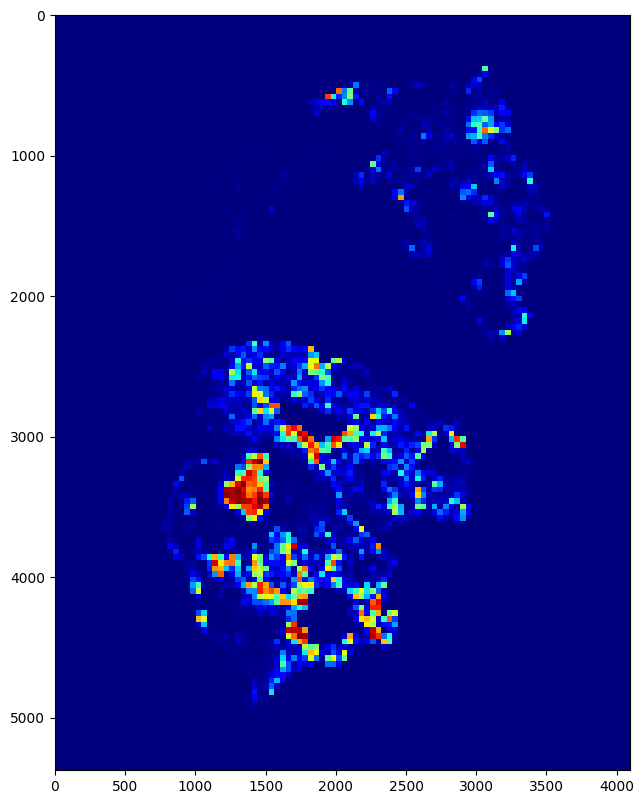

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_aug, cmap = 'jet')
plt.savefig('custom_pred1')

In [0]:
y_true = mask_image.flatten()
y_pred = pred_mask_aug.flatten()

In [0]:
rec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  rec_list.append(recall_score(y_true,new_pred))

In [0]:
print(np.linspace(0.1,0.5,8))

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5       ]


In [0]:
rec_list

[0.8272212785609732,
 0.7729603218711106,
 0.7322646043537138,
 0.7019482908424851,
 0.6675068295852152,
 0.6675068295852152,
 0.5735599164011804,
 0.5551415622333722]

In [0]:
prec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  prec_list.append(precision_score(y_true,new_pred))

In [0]:
prec_list

[0.07779740871613663,
 0.09843301435406698,
 0.1162388170974155,
 0.1353804347826087,
 0.1514133522727273,
 0.1665546875,
 0.16961574074074073,
 0.19356168122270742]

In [0]:
#using probability threshold 0.328
y_pred_new = np.where(y_pred > 0.328, 1, 0)

In [0]:
iou, sens, spec = eval_metrics(y_true, y_pred_new)

In [0]:
print(iou)

0.14079451588883182


In [0]:
print(spec)

0.9781693535497776


In [0]:
print(classification_report(y_true, y_pred_new, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99  21892343
     class 1       0.15      0.67      0.25    127753

    accuracy                           0.98  22020096
   macro avg       0.57      0.82      0.62  22020096
weighted avg       0.99      0.98      0.98  22020096



In [0]:
pred_mask_new = np.where(pred_mask_aug > 0.328 , 1, 0)

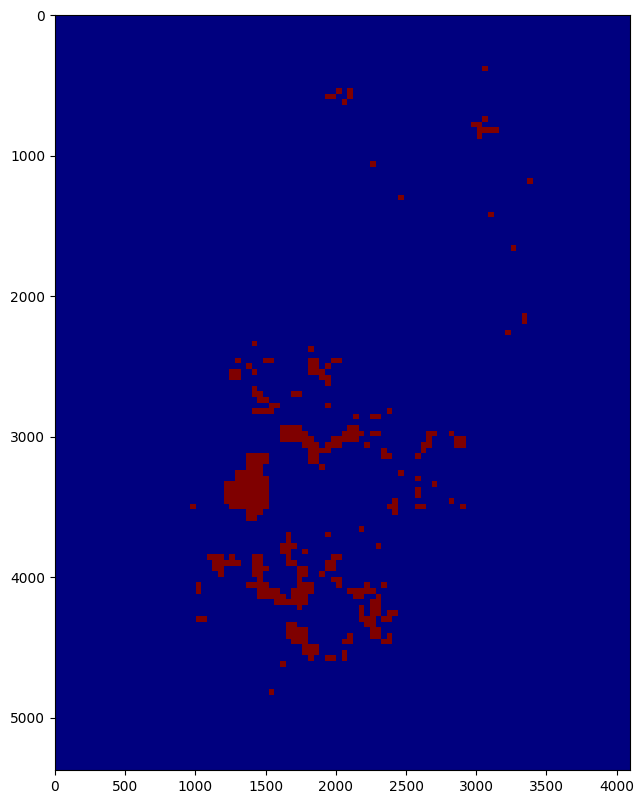

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_new, cmap = 'jet')

Test slide 2:

In [0]:
img_2 = test_img[1]
img_mask_2 = test_mask[1]
slide_2 = open_slide(img_2)
tumor_mask_2 = open_slide(img_mask_2)

In [0]:
pred_mask_aug_2 = predict_test_image(img_2, img_mask_2, model_custom)

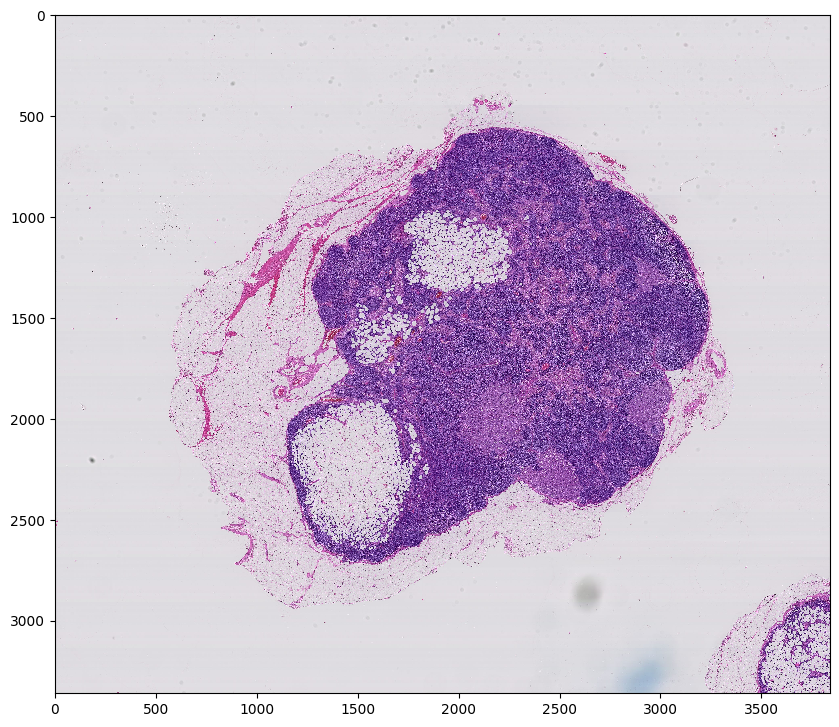

In [0]:
slide_image = read_slide(slide_2, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide_2.level_dimensions[zoom_level][0], 
                         height=slide_2.level_dimensions[zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

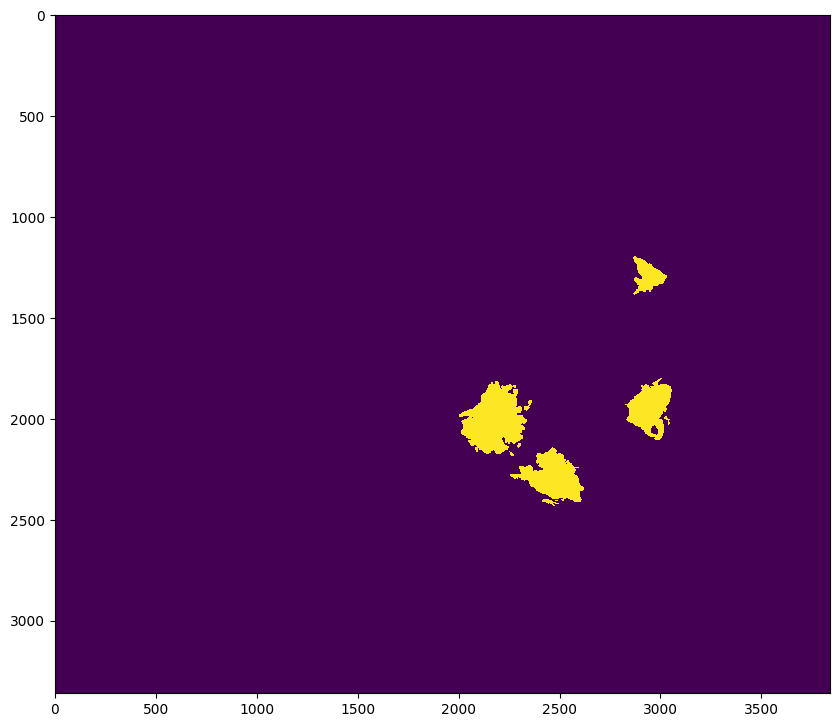

In [0]:
mask_image = read_slide(tumor_mask_2, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide_2.level_dimensions[zoom_level][0], 
                        height=slide_2.level_dimensions[zoom_level][1])
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

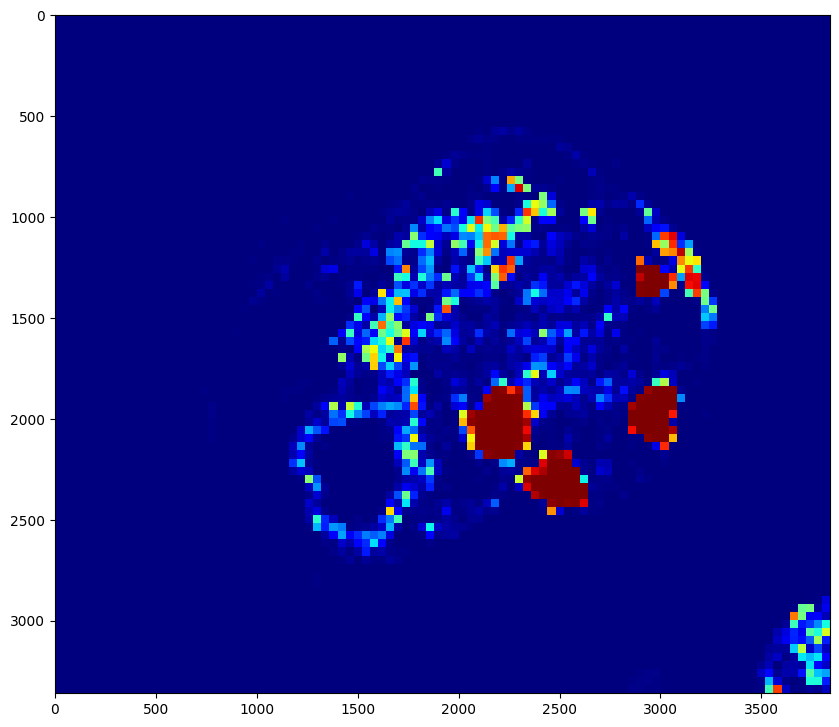

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_aug_2, cmap = 'jet')
plt.savefig('custom_pred2')

In [0]:
y_true_2 = mask_image.flatten()
y_pred_2 = pred_mask_aug_2.flatten()

In [0]:
rec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred_2 > i, 1, 0)
  rec_list.append(recall_score(y_true_2,new_pred))

In [0]:
print(np.linspace(0.1,0.5,8))

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5       ]


In [0]:
rec_list

[0.9623895342931531,
 0.9505263326721874,
 0.9449288689060086,
 0.9401493726242857,
 0.9401493726242857,
 0.9401493726242857,
 0.9355409545092462,
 0.9355409545092462]

In [0]:
prec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred > i, 1, 0)
  prec_list.append(precision_score(y_true_2,new_pred))

In [0]:
prec_list

[0.18474343185550082,
 0.22268912825651302,
 0.255121247113164,
 0.2994788828337875,
 0.327109375,
 0.3651453488372093,
 0.4050740740740741,
 0.4427935222672065]

In [0]:
#using probability threshold 0.5
y_pred_new_2 = np.where(y_pred_2 > 0.5, 1, 0)

In [0]:
iou, sens, spec = eval_metrics(y_true_2, y_pred_new_2)

In [0]:
print(iou)

0.429684449868265


In [0]:
print(spec)

0.9826817207012217


In [0]:
print(classification_report(y_true_2, y_pred_new_2, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       1.00      0.98      0.99  12715351
     class 1       0.44      0.94      0.60    187049

    accuracy                           0.98  12902400
   macro avg       0.72      0.96      0.80  12902400
weighted avg       0.99      0.98      0.99  12902400



In [0]:
pred_mask_new_2 = np.where(pred_mask_aug_2 > 0.5 , 1, 0)

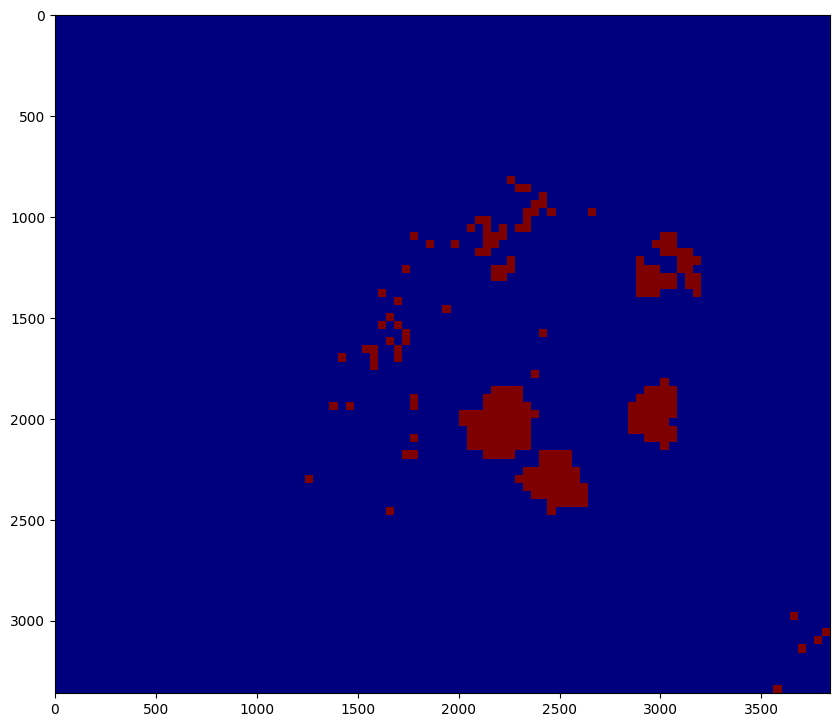

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_new_2, cmap = 'jet')

Test slide 3:

In [0]:
img_3 = test_img[4]
img_mask_3 = test_mask[4]
slide_3 = open_slide(img_3)
tumor_mask_3 = open_slide(img_mask_3)

In [0]:
pred_mask_aug_33 = predict_test_image(img_3, img_mask_3, model_custom)

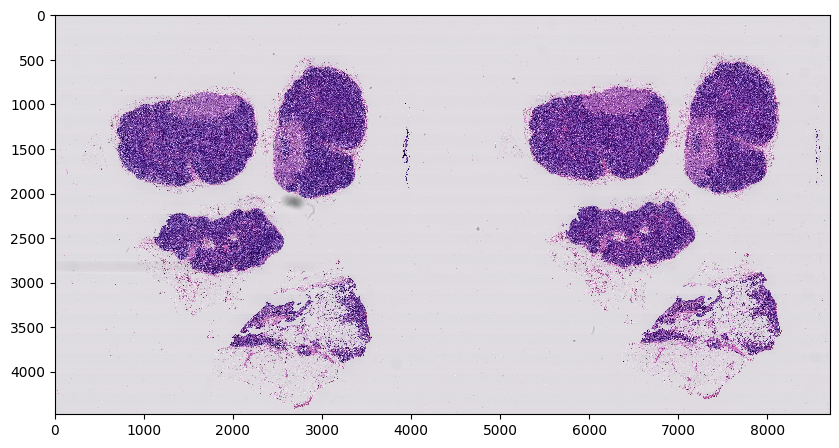

In [0]:
slide_image = read_slide(slide_3, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide_3.level_dimensions[zoom_level][0], 
                         height=slide_3.level_dimensions[zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

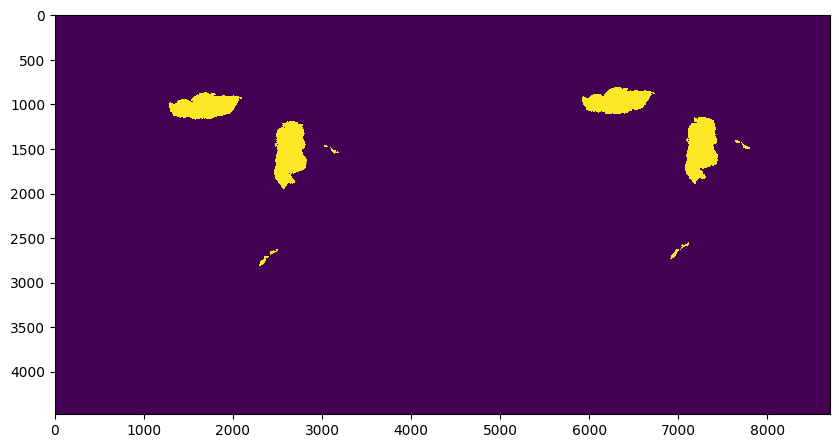

In [0]:
mask_image = read_slide(tumor_mask_3, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide_3.level_dimensions[zoom_level][0], 
                        height=slide_3.level_dimensions[zoom_level][1])
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

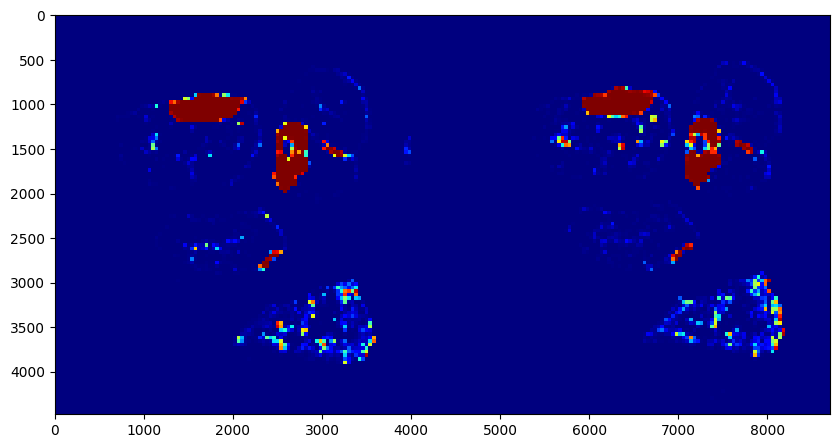

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_aug_33, cmap = 'jet')
plt.savefig('custom_pred3')

In [0]:
y_true_3 = mask_image.flatten()
y_pred_3 = pred_mask_aug_33.flatten()

In [0]:
rec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred_3 > i, 1, 0)
  rec_list.append(recall_score(y_true_3,new_pred))

In [0]:
print(np.linspace(0.1,0.5,8))

[0.1        0.15714286 0.21428571 0.27142857 0.32857143 0.38571429
 0.44285714 0.5       ]


In [0]:
rec_list

[0.9362651072956225,
 0.9310386194927601,
 0.9236180998297826,
 0.9221665198202653,
 0.9145900452802322,
 0.9120254539686518,
 0.9107831467428757,
 0.9086504304754491]

In [0]:
prec_list = []
for i in np.linspace(0.1,0.5,8):
  new_pred = np.where(y_pred_3 > i, 1, 0)
  prec_list.append(precision_score(y_true_3,new_pred))

In [0]:
prec_list

[0.43251354679802956,
 0.4960802556818182,
 0.5300749694002448,
 0.5522230204342273,
 0.5740804886211512,
 0.5964234658298466,
 0.6153503242074928,
 0.6330655646359584]

In [0]:
#using probability threshold 0.5
y_pred_new_3 = np.where(y_pred_3 > 0.5, 1, 0)

In [0]:
iou, sens, spec = eval_metrics(y_true_3, y_pred_new_3)

In [0]:
print(iou)

0.5951855007980219


In [0]:
print(spec)

0.9896684952291361


In [0]:
print(classification_report(y_true_3, y_pred_new_3, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       1.00      0.99      0.99  38243703
     class 1       0.63      0.91      0.75    750217

    accuracy                           0.99  38993920
   macro avg       0.82      0.95      0.87  38993920
weighted avg       0.99      0.99      0.99  38993920



In [0]:
pred_mask_new_3 = np.where(pred_mask_aug_33 > 0.5 , 1, 0)

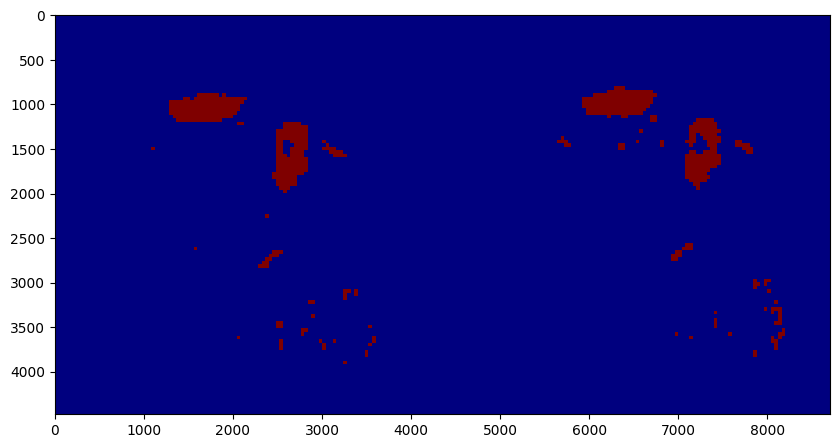

In [0]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(pred_mask_new_3, cmap = 'jet')